## Importing dependencies

In [0]:
#importing the required libraries
! pip install scipy
import numpy as np
import pandas as pd
import pickle
#import matrix_factorization_utilities
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df_ratings = pd.read_csv("/content/gdrive/../path.csv")

In [0]:
df_ratings = df_ratings.drop("date", axis=1)
df_ratings.columns =["MovieID","CustID", "Ratings"] 
df_ratings.head(5)

,MovieID,CustID,Ratings
0,12145,1288391,4.0
1,9438,1588457,3.0
2,14454,1640400,5.0
3,4888,2565022,1.0
4,9410,1979758,3.0


In [0]:
# Checking if the user has rated the same movie twice, in that case we just take max of them
ratings = df_ratings.groupby(['CustID','MovieID']).aggregate(np.max)
len(ratings)
ratings.head()

Ratings
CustID MovieID         
6      7635         2.0
8      4590         4.0
       6497         4.0
79     7381         3.0
       17346        5.0

In [0]:
#Getting the percentage count of each rating value 
count_ratings = df_ratings.groupby('Ratings').count()
count_ratings['perc_total']=round(count_ratings['CustID']*100/count_ratings['CustID'].sum(),1)

In [0]:
count_ratings

,MovieID,CustID,perc_total
Ratings,,,
1.0,9295,9295,4.6
2.0,20175,20175,10.1
3.0,57319,57319,28.7
4.0,67232,67232,33.6
5.0,45979,45979,23.0


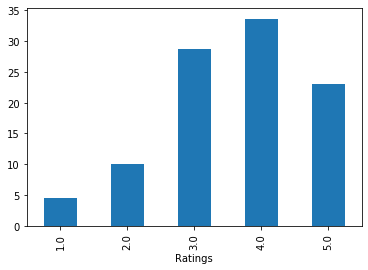

In [0]:
#Visualising the percentage total for each rating
count_ratings['perc_total'].plot.bar()

In [0]:
df_movies = pd.read_csv('/content/gdrive/Shared drives/IDS 561/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['MovieID', 'Year', 'Name'])
df_movies = df_movies.drop('Year', axis=1)
#df_movies.set_index('MovieID', inplace = True)

In [0]:
df_movies.head(5)

,MovieID,Name
0,1,Dinosaur Planet
1,2,Isle of Man TT 2004 Review
2,3,Character
3,4,Paula Abdul's Get Up & Dance
4,5,The Rise and Fall of ECW


In [0]:
#Calculating the sparsity
no_of_users = len(df_ratings['CustID'].unique())
no_of_movies = len(df_ratings['MovieID'].unique())

sparsity = round(1.0 - len(ratings)/(1.0*(no_of_movies*no_of_users)),3)*100
print(str(sparsity) + '%')

100.0%


In [0]:
# Counting the number of unique movies in the dataset.
print('Unique movies:' + str(len(df_ratings['MovieID'].unique())))
print('Unique users:' + str(len(df_ratings['CustID'].unique())))

Unique movies:11520
Unique users:127972


In [0]:
# Finding the average rating for movie and the number of ratings for each movie
avg_movie_rating = pd.DataFrame(df_ratings.groupby('MovieID')['Ratings'].agg(['mean','count']))
avg_movie_rating['MovieID']= avg_movie_rating.index

In [0]:
# inspecting the average movie rating data frame
avg_movie_rating.head()

,mean,count,MovieID
MovieID,,,
1,4.50,2,1
2,3.50,2,2
3,4.75,4,3
6,2.50,2,6
8,3.60,20,8


Merging the two datasets

In [0]:
df_merged = pd.merge(df_ratings, df_movies, on='MovieID')

In [0]:
df_merged.head()

,MovieID,CustID,Ratings,Name
0,12145,1288391,4.0,Absence of Malice
1,12145,1109322,5.0,Absence of Malice
2,12145,628966,5.0,Absence of Malice
3,12145,2255059,5.0,Absence of Malice
4,12145,493920,4.0,Absence of Malice


In [0]:
#Gets the other top 10 movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
    #get all users who watched a specific movie
    df_movie_users_series = df_merged.loc[df_merged['Name']==movie_name]['CustID']
    #convert to a data frame
    df_movie_users = pd.DataFrame(df_movie_users_series,columns=['CustID'])
    #get a list of all other movies watched by these users
    other_movies = pd.merge(df_movie_users,df_merged,on='CustID')
    #get a list of the most commonly watched movies by these other user
    other_users_watched = pd.DataFrame(other_movies.groupby('Name')['CustID'].count()).sort_values('CustID',ascending=False)
    other_users_watched['perc_who_watched'] = round(other_users_watched['CustID']*100/other_users_watched['CustID'][0],1)
    return other_users_watched[:10]

In [0]:
# Getting other top 10 movies which are watched by the people who saw 'Dinosaur Planet'
get_other_movies('Dinosaur Planet')

,CustID,perc_who_watched
Name,,
Dinosaur Planet,2,100.0
Cruel Intentions,1,50.0
GoodFellas: Special Edition,1,50.0
Jaws,1,50.0
Mad Max Beyond Thunderdome,1,50.0


## Implementing kNN

In [0]:
from sklearn.neighbors import NearestNeighbors

In [0]:
avg_movie_rating.head()

,mean,count,MovieID
MovieID,,,
1,4.50,2,1
2,3.50,2,2
3,4.75,4,3
6,2.50,2,6
8,3.60,20,8


In [0]:
#only include movies with more than 10 ratings
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=50]
movie_plus_10_ratings = movie_plus_10_ratings.drop('MovieID', axis=1)
movie_plus_10_ratings.head()

,mean,count
MovieID,,
28,3.643836,73
30,3.673640,239
111,3.065574,61
143,4.069444,72
175,4.106952,187


In [0]:
filtered_ratings = pd.merge(movie_plus_10_ratings, df_ratings, on="MovieID")

In [0]:
filtered_ratings.head()

,MovieID,mean,count,CustID,Ratings
0,28,3.643836,73,484292,4.0
1,28,3.643836,73,2001296,3.0
2,28,3.643836,73,60171,3.0
3,28,3.643836,73,2137060,3.0
4,28,3.643836,73,1095936,5.0


In [0]:
#create a matrix table with movieIds on the rows and userIds in the columns.
#replace NAN values with 0
movie_wide = filtered_ratings.pivot(index = 'MovieID', columns = 'CustID', values = 'Ratings').fillna(0)
movie_wide.head()

CustID,6,8,94,97,130,134,169,178,188,192,199,201,265,296,299,314,352,383,424,437,462,481,544,561,578,592,602,624,657,684,688,692,695,735,750,769,788,815,906,981,...,2648451,2648465,2648502,2648546,2648589,2648597,2648599,2648623,2648633,2648670,2648674,2648730,2648734,2648745,2648747,2648767,2648768,2648826,2648827,2648838,2648845,2648861,2648873,2648885,2648928,2649027,2649052,2649057,2649077,2649116,2649231,2649257,2649267,2649308,2649336,2649370,2649375,2649379,2649388,2649429
MovieID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#specify model parameters
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
#fit model to the data set
model_knn.fit(movie_wide)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [0]:
#Gets the top 10 nearest neighbours got the movie
def print_similar_movies(query_index) :
    #get the list of user ratings for a specific userId
    query_index_movie_ratings = movie_wide.loc[query_index,:].values.reshape(1,-1)
    #get the closest 10 movies and their distances from the movie specified
    distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
    #write a lopp that prints the similar movies for a specified movie.
    for i in range(0,len(distances.flatten())):
        #get the title of the random movie that was chosen
        get_movie = df_movies.loc[df_movies['MovieID']==query_index]['Name']
        #for the first movie in the list i.e closest print the title
        if i==0:
            print('Recommendations for {0}:\n'.format(get_movie))
        else :
            #get the indiciees for the closest movies
            indices_flat = indices.flatten()[i]
            #get the title of the movie
            get_movie = df_movies.loc[df_movies['MovieID']==movie_wide.iloc[indices_flat,:].name]['Name']
            #print the movie
            print('{0}: {1}, with distance of {2}:'.format(i,get_movie,distances.flatten()[i]))

In [0]:
print_similar_movies(30)

Recommendations for 29    Something's Gotta Give
Name: Name, dtype: object:

1: 329    Wild Things
Name: Name, dtype: object, with distance of 0.975179578954264:
2: 9457    Kingdom of Heaven
Name: Name, dtype: object, with distance of 0.9836149076392955:
3: 13317    The Core
Name: Name, dtype: object, with distance of 0.9860135345876989:
4: 4545    Chasing Liberty
Name: Name, dtype: object, with distance of 0.9864740750290822:
5: 8044    Open Range
Name: Name, dtype: object, with distance of 0.9870408818068898:
6: 10077    Indecent Proposal
Name: Name, dtype: object, with distance of 0.9880962610710223:
7: 2494    Exit Wounds
Name: Name, dtype: object, with distance of 0.9889654862181552:
8: 15757    Amadeus
Name: Name, dtype: object, with distance of 0.9900316364346116:
9: 16302    Atlantis: The Lost Empire
Name: Name, dtype: object, with distance of 0.9900727407709027:
10: 11397    Airplane!
Name: Name, dtype: object, with distance of 0.990546464587432:


### Training the data

In [0]:
#get ordered list of movieIds
item_indices = pd.DataFrame(sorted(list(set(df_ratings['MovieID']))),columns=['MovieID'])
#add in data frame index value to data frame
item_indices['movie_index']=item_indices.index
#inspect data frame
item_indices.head()

,MovieID,movie_index
0,1,0
1,2,1
2,3,2
3,6,3
4,8,4


In [0]:
#get ordered list of User ID
user_indices = pd.DataFrame(sorted(list(set(df_ratings['CustID']))),columns=['CustID'])
#add in data frame index value to data frame
user_indices['user_index']=user_indices.index
#inspect data frame
user_indices.head()

,CustID,user_index
0,6,0
1,8,1
2,79,2
3,87,3
4,94,4


In [0]:
#join the movie indices
df_with_index = pd.merge(df_ratings,item_indices,on='MovieID')
#join the user indices
df_with_index=pd.merge(df_with_index,user_indices,on='CustID')
#inspec the data frame
df_with_index.head()

,MovieID,CustID,Ratings,movie_index,user_index
0,12145,1288391,4.0,7830,62206
1,12299,1288391,4.0,7924,62206
2,4330,1288391,3.0,2807,62206
3,12476,1288391,5.0,8043,62206
4,12145,1109322,5.0,7830,53580


In [0]:
#import train_test_split module
from sklearn.model_selection import train_test_split
#take 80% as the training set and 20% as the test set
df_train, df_test= train_test_split(df_with_index,test_size=0.3)
print(len(df_train))
print(len(df_test))

140000
60000


In [0]:
n_users = df_ratings.CustID.unique().shape[0]
n_items = df_ratings.MovieID.unique().shape[0]
print(n_users)
print(n_items)

127972
11520


In [0]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_train.itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    train_data_matrix[line[5], line[4]] = line[3]
train_data_matrix.shape

(127972, 11520)

In [0]:
#Create two user-item matrices, one for training and another for testing
test_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in df_test[:1].itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    #print(line[2])
    test_data_matrix[line[5], line[4]] = line[3]
    #train_data_matrix[line['movieId'], line['userId']] = line['rating']
test_data_matrix.shape

(127972, 11520)

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    #select prediction values that are non-zero and flatten into 1 array
    prediction = prediction[ground_truth.nonzero()].flatten() 
    #select test values that are non-zero and flatten into 1 array
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    #return RMSE between values
    return sqrt(mean_squared_error(prediction, ground_truth))

In [0]:
#Calculate the rmse sscore of SVD using different values of k (latent features)
rmse_list = []
for i in [2]:
    #apply svd to the test data
    u,s,vt = svds(train_data_matrix,k=i)
    #get diagonal matrix
    s_diag_matrix=np.diag(s)
    #predict x with dot product of u s_diag and vt
    X_pred = np.dot(np.dot(u,s_diag_matrix),vt)
    #calculate rmse score of matrix factorisation predictions
    rmse_score = rmse(X_pred,test_data_matrix)
    rmse_list.append(rmse_score)
    print("Matrix Factorisation with " + str(i) +" latent features has a RMSE of " + str(rmse_score))